In [142]:
# Importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from sklearn import preprocessing
import textwrap
import seaborn as sns
import math
from imblearn.under_sampling import RandomUnderSampler 

import warnings
warnings.filterwarnings("ignore")
# TODO: Shift all the CSV reading scripts to the first block

In [143]:
# Rename all the unnamed columns for consistency and easy data handeling
first_columns = ["Participant_ID", "RSVP", "TTS", "Trial_No"]

with open('Data/LanePositionDifference.csv') as f:
    lpd_num_cols = max(len(line.split(',')) for line in f)
with open('Data/BrakingInput.csv') as f:
    bi_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelAngles.csv') as f:
    swa_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelVelocity.csv') as f:
    swv_num_cols = max(len(line.split(',')) for line in f)

# Extracting the driving performance metric data
rt_df = pd.read_csv("Data/ReactionTimes.csv")
lpd_df = pd.read_csv("Data/LanePositionDifference.csv", names=(first_columns + ["DP" + str(i) for i in range(0, lpd_num_cols - 4)]), skiprows = 1)
bi_df = pd.read_csv("Data/BrakingInput.csv", names=(first_columns + ["DP" + str(i) for i in range(0, bi_num_cols - 4)]), skiprows = 1)
swa_df = pd.read_csv("Data/SteeringWheelAngles.csv", names=(first_columns + ["DP" + str(i) for i in range(0, swa_num_cols - 4)]), skiprows = 1)
swv_df = pd.read_csv("Data/SteeringWheelVelocity.csv", names=(first_columns + ["DP" + str(i) for i in range(0, swv_num_cols - 4)]), skiprows = 1)
scenario_df = pd.read_csv("Data/Scenario.csv")

# Extracting reading comprehension data
comp_test_df = pd.read_csv("Data/ComprehensionTest.csv")

# Extracting the survey data
# You must manually change the columns names in the NASA-TLX Form
nasa_tlx = pd.read_csv("Data/NASA_TLX.csv")
# pre_study = pd.read_csv("Data/Pre_Study.csv")
# post_study = pd.read_csv("Data/Post_Study.csv")



# Giving column names to all the tables that don't have a name.
rt_columns = first_columns + ["DP" + str(i) for i in range(0, rt_df.shape[1] - 4)]
rt_df.columns = rt_columns
scenario_columns = first_columns + ["DP" + str(i) for i in range(0, scenario_df.shape[1] - 4)]
scenario_df.columns = scenario_columns

In [144]:
# Utility Methods here
def is_outlier(data_point, q1, q3):
    IQR = q3 - q1
    return data_point < q1 - 1.5*IQR or data_point > q3 + 1.5*IQR

def get_stats(np_array):
    q1, q3 = np.percentile(np.sort(np_array), [25, 75])
    return (q1, q3)

def remove_outliers(df, column_name):
    q1_rsvp, q3_rsvp = get_stats(np.array(df[df["TPTAA"]=="RSVPNAA"][column_name].values))
    q1_rsvpa, q3_rsvpa = get_stats(np.array(df[df["TPTAA"]=="RSVPAA"][column_name].values))
    q1_stp, q3_stp = get_stats(np.array(df[df["TPTAA"]=="STPNAA"][column_name].values))
    q1_stpa, q3_stpa = get_stats(np.array(df[df["TPTAA"]=="STPAA"][column_name].values))
    index_list = []
    for i in range(0, df.shape[0]):
        if df.iloc[i]["TPTAA"] == "RSVPNAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvp, q3_rsvp):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "RSVPAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvpa, q3_rsvpa):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "STPNAA":
            if is_outlier(df.iloc[i][column_name], q1_stp, q3_stp):
                index_list.append(i)
        elif is_outlier(df.iloc[i][column_name], q1_stpa, q3_stpa):
                index_list.append(i)
    display(index_list)
    df.drop(index_list, axis=0, inplace=True)
    df.reset_index(inplace=True)

In [145]:
exclusion = ['P01', 'P02', 'P03', 'P04', 'P05', 'P09']

# Excluding certain participants' driving performance
for participant in exclusion:
    rt_df = rt_df[rt_df["Participant_ID"] != participant]
    lpd_df = lpd_df[lpd_df["Participant_ID"] != participant]
    bi_df = bi_df[bi_df["Participant_ID"] != participant]
    swa_df = swa_df[swa_df["Participant_ID"] != participant]
    swv_df = swv_df[swv_df["Participant_ID"] != participant]

# Excluding certain participants' reading comprehension performance
for participant in exclusion:
    comp_test_df = comp_test_df[comp_test_df["Q1"] != participant]
    
# Exclusing certain participants' subjective surveys
for participant in exclusion:
    nasa_tlx = nasa_tlx[nasa_tlx["Q1"] != participant]
#     pre_study = pre_study[pre_study["ID"] != participant]
#     post_study = post_study[post_study["Q1"] != participant]

[1]

Shapiro Test for RT_stp; p-value:  0.5679965019226074
Shapiro Test for RT_rsvp; p-value:  0.9350904822349548
Shapiro Test for RT_stpa; p-value:  0.23670734465122223
Shapiro Test for RT_rsvpa; p-value:  0.6495641469955444
Test: RT_rsvp < RT_stp [p value: 0.84375]
Test: RT_rsvpa < RT_stpa [p value: 0.23170163170163172]
Test: RT_rsvpa < RT_rsvp [p value: 0.5224553224553226]
Test: RT_stpa < RT_stp [p value: 0.9475524475524475]


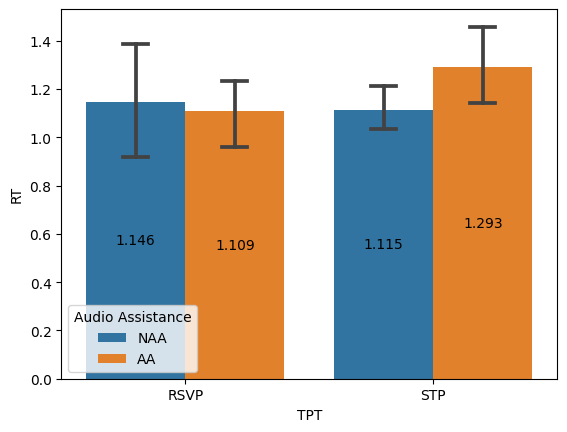

In [150]:
# Restructuring the data frame.
rt_refined = pd.DataFrame(columns = ["Participant_ID", "TPT", "Audio Assistance", "RT"])
rt_refined["Participant_ID"] = rt_refined["Participant_ID"].astype(str)
rt_refined["TPT"] = rt_refined["TPT"].astype(str)
rt_refined["Audio Assistance"] = rt_refined["Audio Assistance"].astype(str)
rt_refined["RT"] = rt_refined["RT"].astype(float)

for participant in rt_df["Participant_ID"].unique():
    p_data = rt_df[(rt_df["Participant_ID"] == participant)]
    value_1 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["DP0"].values[0]
    value_2 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)]["DP0"].values[1]
    if (value_1 == 0 or value_2 == 0):
        value = value_1 + value_2
        value = Nan if value == 0 else value
    else:
        value = (value_1 + value_2)/2
    new_arr_1 = [participant, "RSVP", "NAA", value]
    
    value_1 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["DP0"].values[0]
    value_2 = p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)]["DP0"].values[1]
    if (value_1 == 0 or value_2 == 0):
        value = value_1 + value_2
        value = Nan if value == 0 else value
    else:
        value = (value_1 + value_2)/2
    new_arr_2 = [participant, "RSVP", "AA", value]
    
    value_1 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["DP0"].values[0]
    value_2 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)]["DP0"].values[1]
    if (value_1 == 0 or value_2 == 0):
        value = value_1 + value_2
        value = Nan if value == 0 else value
    else:
        value = (value_1 + value_2)/2
    new_arr_3 = [participant, "STP", "NAA", value]
    
    value_1 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)]["DP0"].values[0]
    value_2 = p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)]["DP0"].values[1]
    if (value_1 == 0 or value_2 == 0):
        value = value_1 + value_2
        value = Nan if value == 0 else value
    else:
        value = (value_1 + value_2)/2
    new_arr_4 = [participant, "STP", "AA", value]
    
    rt_refined.loc[len(rt_refined)] = new_arr_1
    rt_refined.loc[len(rt_refined)] = new_arr_2
    rt_refined.loc[len(rt_refined)] = new_arr_3
    rt_refined.loc[len(rt_refined)] = new_arr_4

    
# Combine columns TPT and Audio Assistance
rt_combined = pd.DataFrame()
rt_combined["TPTAA"] = rt_refined["TPT"].values + rt_refined["Audio Assistance"].values
rt_combined["RT"] = rt_refined["RT"].values

# Removing the outliers from the data frame
remove_outliers(rt_combined, "RT")

# Undersampling the data set
rus = RandomUnderSampler(random_state=42)
rt_combined_c1, rt_combined_c2 = rus.fit_resample(rt_combined["TPTAA"].values.reshape((-1, 1)), rt_combined["RT"].astype(str))
rt_combined = pd.DataFrame()
rt_combined["TPTAA"] = rt_combined_c1.reshape((-1,))
rt_combined["RT"] = rt_combined_c2.astype(float)

# Creating sperate arrays for analysis
rt_stp = rt_combined[rt_combined["TPTAA"] == "STPNAA"]["RT"].values
rt_stpa = rt_combined[rt_combined["TPTAA"] == "STPAA"]["RT"].values
rt_rsvp = rt_combined[rt_combined["TPTAA"] == "RSVPNAA"]["RT"].values
rt_rsvpa = rt_combined[rt_combined["TPTAA"] == "RSVPAA"]["RT"].values

# Test if the distribution is normal.
print("Shapiro Test for RT_stp; p-value: ", stats.shapiro(rt_stp)[1])
print("Shapiro Test for RT_rsvp; p-value: ", stats.shapiro(rt_rsvp)[1])
print("Shapiro Test for RT_stpa; p-value: ", stats.shapiro(rt_stpa)[1])
print("Shapiro Test for RT_rsvpa; p-value: ", stats.shapiro(rt_rsvpa)[1])

data_is_normal = False

if (data_is_normal):
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: RT_rsvp < RT_stp
    print("H_a: RT_rsvp = RT_stp ; H_a: RT_rsvp < RT_stp")
    print(stats.ttest_rel(a = rt_rsvp, b = rt_stp, alternative = "less"))
    print("H_a: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa < RT_stpa")
    print(stats.ttest_rel(a = rt_rsvpa, b = rt_stpa, alternative = "less"))

    # Test if H_a: RT_aae < RT_aad
    print("H_a: RT_aae = RT_aad ; H_a: RT_aae < RT_aad for RSVP")
    print(stats.ttest_rel(a = rt_rsvp, b = rt_rsvpa, alternative = "less"))
    print("H_a: RT_aae = RT_aad ; H_a: RT_aae < RT_aad for STP")
    print(stats.ttest_rel(a = rt_stp, b = rt_stpa, alternative = "less"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(rt_rsvp, rt_stp, alternative='less')
    print("Test: RT_rsvp < RT_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(rt_rsvpa, rt_stpa, alternative='less')
    print("Test: RT_rsvpa < RT_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(rt_rsvpa, rt_rsvp, alternative='less')
    print("Test: RT_rsvpa < RT_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(rt_stpa, rt_stp, alternative='less')
    print("Test: RT_stpa < RT_stp [p value: {}]".format(p4))

plot = sns.barplot(data=rt_refined, x="TPT", y="RT", hue="Audio Assistance", capsize=0.1)

for p in plot.containers:
    plot.bar_label(p, fmt='%.3f', label_type='center')

Shapiro Test for alpo_stp; p-value: 0.01130559854209423
Shapiro Test for alpo_rsvp; p-value: 0.5433734655380249
Shapiro Test for alpo_stpa; p-value: 0.011122220195829868
Shapiro Test for alpo_rsvpa; p-value: 4.400273610372096e-05 

Test: ALPO_rsvp < ALPO_stp [p value: 0.5100250244140625]
Test: ALPO_rsvpa < ALPO_stpa [p value: 0.9790865243876705]
Test: ALPO_rsvpa < ALPO_rsvp [p value: 0.8862326837173027]
Test: ALPO_stpa < ALPO_stp [p value: 0.23118987493362808]
    TPT         AA Disabled          AA Enabled
0   STP  0.6003249667050677  0.5764652456401391
1  RSVP  0.6170587350864583  0.7439137048168442


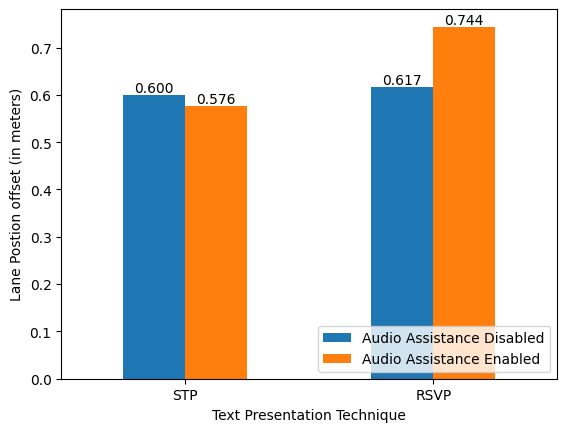

In [84]:
# Analyzing the Average Lane Position Offset.
avg_lane_offsets = []
for i in range(0, lpd_df.shape[0]):
    dp_array = [dp for dp in lpd_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    avg_lane_offsets.append(sum(dp_array)/len(dp_array))
lpd_df["AVG"] = avg_lane_offsets

# Create seperate arrays for 2 x 2 cases
alpo_stp = lpd_df[(lpd_df["RSVP"] == 0) & (lpd_df["TTS"] == 0)]["AVG"].values
alpo_stpa = lpd_df[(lpd_df["RSVP"] == 0) & (lpd_df["TTS"] == 1)]["AVG"].values
alpo_rsvp = lpd_df[(lpd_df["RSVP"] == 1) & (lpd_df["TTS"] == 0)]["AVG"].values
alpo_rsvpa = lpd_df[(lpd_df["RSVP"] == 1) & (lpd_df["TTS"] == 1)]["AVG"].values

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for alpo_stp; p-value:", stats.shapiro(alpo_stp)[1])
print("Shapiro Test for alpo_rsvp; p-value:", stats.shapiro(alpo_rsvp)[1])
print("Shapiro Test for alpo_stpa; p-value:", stats.shapiro(alpo_stpa)[1])
print("Shapiro Test for alpo_rsvpa; p-value:", stats.shapiro(alpo_rsvpa)[1], "\n")
# Test is the distribution is normal.

data_is_normal = False
if data_is_normal:
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: alpo_rsvp < alpotp
    print("H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp < alpo_stp")
    print(stats.ttest_rel(a = alpo_rsvp, b = alpo_stp, alternative = "less"))
    print("\nH_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa < alpo_stpa")
    print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_stpa, alternative = "less"))

    # Test if H_a: alpo_aae < alpo_aad
    print("\nH_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa < alpo_rsvp")
    print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_rsvp, alternative = "less"))
    print("\nH_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa < alpo_stp")
    print(stats.ttest_rel(a = alpo_stpa, b = alpo_stp, alternative = "less"))

    # Test if H_a: alpo_rsvp > alpo_stp
    print("\nH_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp > alpo_stp")
    print(stats.ttest_rel(a = alpo_rsvp, b = alpo_stp, alternative = "greater"))
    print("\nH_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa > alpo_stpa")
    print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_stpa, alternative = "greater"))

    # Test if H_a: alpo_aae > alpo_aad
    print("\nH_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa > alpo_rsvp")
    print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_rsvp, alternative = "greater"))
    print("\nH_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa > alpo_stp")
    print(stats.ttest_rel(a = alpo_stpa, b = alpo_stp, alternative = "greater"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(alpo_rsvp, alpo_stp, alternative='less')
    print("Test: ALPO_rsvp < ALPO_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(alpo_rsvpa, alpo_stpa, alternative='less')
    print("Test: ALPO_rsvpa < ALPO_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(alpo_rsvpa, alpo_rsvp, alternative='less')
    print("Test: ALPO_rsvpa < ALPO_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(alpo_stpa, alpo_stp, alternative='less')
    print("Test: ALPO_stpa < ALPO_stp [p value: {}]".format(p4))
    
# CONCLUSION:
# With audio assistance, RSVP was better than STP
# RSVP with audio assistance is better than RSVP without audio assistance

# Generating data frame for ALPO results
alpo_results_array = np.array([
    ["STP",np.mean(alpo_stp), np.mean(alpo_stpa)],
    ["RSVP",np.mean(alpo_rsvp), np.mean(alpo_rsvpa)],
])
alpo_results_df = pd.DataFrame(alpo_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(alpo_results_df)

# Converting the column types
alpo_results_df["TPT"] = alpo_results_df["TPT"].astype(str)
alpo_results_df["AA Disabled"] = alpo_results_df["AA Disabled"].astype(float)
alpo_results_df["AA Enabled"] = alpo_results_df["AA Enabled"].astype(float)

# Plotting paired bar graph
bplot = alpo_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Lane Postion offset (in meters)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

Shapiro Test for msav_stp; p-value: 0.1484365612268448
Shapiro Test for msav_rsvp; p-value: 0.009839325211942196
Shapiro Test for msav_stpa; p-value: 0.04323597624897957
Shapiro Test for msav_rsvpa; p-value: 6.836703687440604e-05 

Test: MSAV_rsvp < MSAV_stp [p value: 0.4301300048828125]
Test: MSAV_rsvpa < MSAV_stpa [p value: 0.3865786351026259]
Test: MSAV_rsvpa < MSAV_rsvp [p value: 0.3660756131629792]
Test: MSAV_stpa < MSAV_stp [p value: 0.6398942123851592]
    TPT   AA Disabled           AA Enabled
0   STP  0.1797688125  0.20358831249999998
1  RSVP  0.1701811875  0.23306494117647059


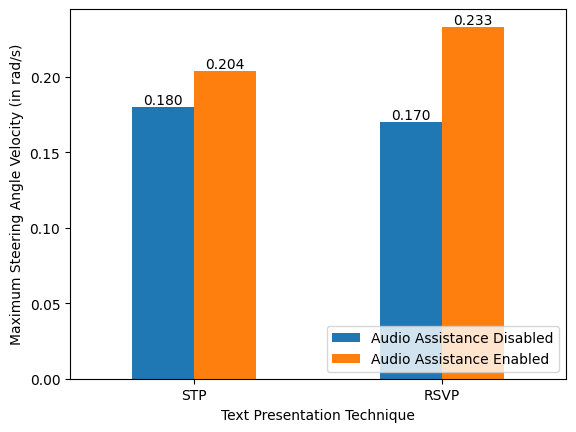

In [42]:
# Analyzing the Maximum Steering Angle Velocity
MSVs = []
for i in range(0, swv_df.shape[0]):
    dp_array = [dp for dp in swv_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MSVs.append(max(dp_array))
swv_df["MAX"] = MSVs
# Create seperate arrays for 2 x 2 cases
msav_stp = swv_df[(swv_df["RSVP"] == 0) & (swv_df["TTS"] == 0)]["MAX"].values
msav_stpa = swv_df[(swv_df["RSVP"] == 0) & (swv_df["TTS"] == 1)]["MAX"].values
msav_rsvp = swv_df[(swv_df["RSVP"] == 1) & (swv_df["TTS"] == 0)]["MAX"].values
msav_rsvpa = swv_df[(swv_df["RSVP"] == 1) & (swv_df["TTS"] == 1)]["MAX"].values

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for msav_stp; p-value:", stats.shapiro(msav_stp)[1])
print("Shapiro Test for msav_rsvp; p-value:", stats.shapiro(msav_rsvp)[1])
print("Shapiro Test for msav_stpa; p-value:", stats.shapiro(msav_stpa)[1])
print("Shapiro Test for msav_rsvpa; p-value:", stats.shapiro(msav_rsvpa)[1], "\n")
# Test is the distribution is normal.
data_is_normal = False
if data_is_normal:
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: msav_rsvp < msav_stp
    print("H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp < msav_stp")
    print(stats.ttest_rel(a = msav_rsvp, b = msav_stp, alternative = "less"))
    print("\nH_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa < msav_stpa")
    print(stats.ttest_rel(a = msav_rsvpa, b = msav_stpa, alternative = "less"))

    # Test if H_a: msav_aae < msav_aad
    print("\nH_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa < msav_rsvp")
    print(stats.ttest_rel(a = msav_rsvpa, b = msav_rsvp, alternative = "less"))
    print("\nH_0: msav_stpa = msav_stp ; H_a: msav_stpa < msav_stp")
    print(stats.ttest_rel(a = msav_stpa, b = msav_stp, alternative = "less"))

    # Test if H_a: msav_rsvp > msav_stp
    print("\nH_0: msav_rsvp = msav_stp ; H_a: msav_rsvp > msav_stp")
    print(stats.ttest_rel(a = msav_rsvp, b = msav_stp, alternative = "greater"))
    print("\nH_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa > msav_stpa")
    print(stats.ttest_rel(a = msav_rsvpa, b = msav_stpa, alternative = "greater"))

    # Test if H_a: msav_aae > msav_aad
    print("\nH_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa > msav_rsvp")
    print(stats.ttest_rel(a = msav_rsvpa, b = msav_rsvp, alternative = "greater"))
    print("\nH_0: msav_stpa = msav_stp ; H_a: msav_stpa > msav_stp")
    print(stats.ttest_rel(a = msav_stpa, b = msav_stp, alternative = "greater"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(msav_rsvp, msav_stp, alternative='less')
    print("Test: MSAV_rsvp < MSAV_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(msav_rsvpa, msav_stpa, alternative='less')
    print("Test: MSAV_rsvpa < MSAV_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(msav_rsvpa, msav_rsvp, alternative='less')
    print("Test: MSAV_rsvpa < MSAV_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(msav_stpa, msav_stp, alternative='less')
    print("Test: MSAV_stpa < MSAV_stp [p value: {}]".format(p4))
# CONCLUSION:
# RSVP with audio assistance is better than RSVP without audio assistance

# Generating data frame for MSAV results
msav_results_array = np.array([
    ["STP",np.mean(msav_stp), np.mean(msav_stpa)],
    ["RSVP",np.mean(msav_rsvp), np.mean(msav_rsvpa)],
])
msav_results_df = pd.DataFrame(msav_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(msav_results_df)

# Converting the column types
msav_results_df["TPT"] = msav_results_df["TPT"].astype(str)
msav_results_df["AA Disabled"] = msav_results_df["AA Disabled"].astype(float)
msav_results_df["AA Enabled"] = msav_results_df["AA Enabled"].astype(float)

# Plotting paired bar graph
bplot = msav_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Maximum Steering Angle Velocity (in rad/s)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

Shapiro Test for sdswa_stp; p-value: 0.6212365031242371
Shapiro Test for sdswa_rsvp; p-value: 0.792975664138794
Shapiro Test for sdswa_stpa; p-value: 0.44356560707092285
Shapiro Test for sdswa_rsvpa; p-value: 0.001727404072880745 

Test: SDSWA_rsvp < SDSWA_stp [p value: 0.71905517578125]
Test: SDSWA_rsvpa < SDSWA_stpa [p value: 0.9976559588261853]
Test: SDSWA_rsvpa < SDSWA_rsvp [p value: 0.9772075001494656]
Test: SDSWA_stpa < SDSWA_stp [p value: 0.5821079371298694]
    TPT         AA Disabled           AA Enabled
0   STP  0.2603392093960931  0.27398835775822417
1  RSVP  0.2952703362392748    0.424451948501682


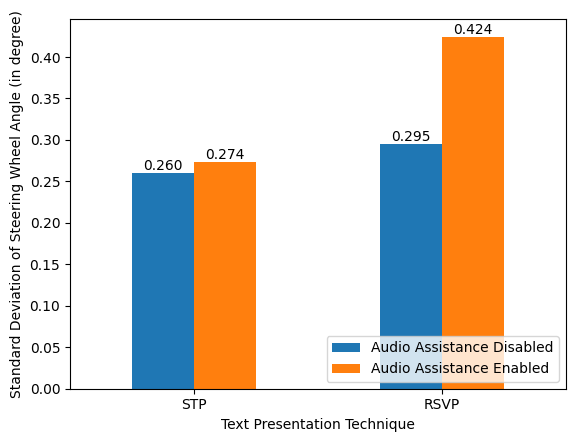

In [43]:
# Analyzing the Standard Deviation of Steering Wheel Angle
SDSWAs = []
for i in range(0, swa_df.shape[0]):
    dp_array = [dp for dp in lpd_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SDSWAs.append(np.std(dp_array))
swa_df["SD"] = SDSWAs

# Create seperate arrays for 2 x 2 cases
sdswa_stp = swa_df[(swa_df["RSVP"] == 0) & (swa_df["TTS"] == 0)]["SD"].values
sdswa_stpa = swa_df[(swa_df["RSVP"] == 0) & (swa_df["TTS"] == 1)]["SD"].values
sdswa_rsvp = swa_df[(lpd_df["RSVP"] == 1) & (swa_df["TTS"] == 0)]["SD"].values
sdswa_rsvpa = swa_df[(lpd_df["RSVP"] == 1) & (swa_df["TTS"] == 1)]["SD"].values

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for sdswa_stp; p-value:", stats.shapiro(sdswa_stp)[1])
print("Shapiro Test for sdswa_rsvp; p-value:", stats.shapiro(sdswa_rsvp)[1])
print("Shapiro Test for sdswa_stpa; p-value:", stats.shapiro(sdswa_stpa)[1])
print("Shapiro Test for sdswa_rsvpa; p-value:", stats.shapiro(sdswa_rsvpa)[1], "\n")
# Test is the distribution is normal.

data_is_normal = False

if data_is_normal:
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: sdswa_rsvp < sdswa_stp
    print("H_0: sdswa_rsvp = sdswa_stp ; H_a: sdswa_rsvp < sdswa_stp")
    print(stats.ttest_rel(a = sdswa_rsvp, b = sdswa_stp, alternative = "less"))
    print("\nH_0: sdswa_rsvpa = sdswa_stpa ; H_a: sdswa_rsvpa < sdswa_stpa")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_stpa, alternative = "less"))

    # Test if H_a: sdswa_aae < sdswa_aad
    print("\nH_0: sdswa_rsvpa = sdswa_rsvp ; H_a: sdswa_rsvpa < sdswa_rsvp")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_rsvp, alternative = "less"))
    print("\nH_0: sdswa_stpa = sdswa_stp ; H_a: sdswa_stpa < sdswa_stp")
    print(stats.ttest_rel(a = sdswa_stpa, b = sdswa_stp, alternative = "less"))

    # Test if H_a: sdswa_rsvp > sdswa_stp
    print("\nH_0: sdswa_rsvp = sdswa_stp ; H_a: sdswa_rsvp > sdswa_stp")
    print(stats.ttest_rel(a = sdswa_rsvp, b = sdswa_stp, alternative = "greater"))
    print("\nH_0: sdswa_rsvpa = sdswa_stpa ; H_a: sdswa_rsvpa > sdswa_stpa")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_stpa, alternative = "greater"))

    # Test if H_a: sdswa_aae > sdswa_aad
    print("\nH_0: sdswa_rsvpa = sdswa_rsvp ; H_a: sdswa_rsvpa > sdswa_rsvp")
    print(stats.ttest_rel(a = sdswa_rsvpa, b = sdswa_rsvp, alternative = "greater"))
    print("\nH_0: sdswa_stpa = sdswa_stp ; H_a: sdswa_stpa > sdswa_stp")
    print(stats.ttest_rel(a = sdswa_stpa, b = sdswa_stp, alternative = "greater"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(sdswa_rsvp, sdswa_stp, alternative='less')
    print("Test: SDSWA_rsvp < SDSWA_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(sdswa_rsvpa, sdswa_stpa, alternative='less')
    print("Test: SDSWA_rsvpa < SDSWA_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(sdswa_rsvpa, sdswa_rsvp, alternative='less')
    print("Test: SDSWA_rsvpa < SDSWA_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(sdswa_stpa, sdswa_stp, alternative='less')
    print("Test: SDSWA_stpa < SDSWA_stp [p value: {}]".format(p4))

# CONCLUSION:
# No significant difference was observed

# Generating data frame for SDSWA results
sdswa_results_array = np.array([
    ["STP",np.mean(sdswa_stp), np.mean(sdswa_stpa)],
    ["RSVP",np.mean(sdswa_rsvp), np.mean(sdswa_rsvpa)],
])
sdswa_results_df = pd.DataFrame(sdswa_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(sdswa_results_df)

# Converting the column types
sdswa_results_df["TPT"] = sdswa_results_df["TPT"].astype(str)
sdswa_results_df["AA Disabled"] = sdswa_results_df["AA Disabled"].astype(float)
sdswa_results_df["AA Enabled"] = sdswa_results_df["AA Enabled"].astype(float)

# Plotting paired bar graph
bplot = sdswa_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Standard Deviation of Steering Wheel Angle (in degree)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

    TPT          AA Disabled           AA Enabled
0   STP  0.40653211448882565  0.31323797991307195
1  RSVP  0.38199625062155873   0.3815785489739884
Shapiro Test for BIR_stp; p-value:  0.9453693628311157
Shapiro Test for BIR_rsvp; p-value:  0.5522266030311584
Shapiro Test for BIR_stpa; p-value:  0.5519227385520935
Shapiro Test for BIR_rsvpa; p-value:  0.18028917908668518
Test: BIR_rsvp < BIR_stp [p value: 0.34547237844896683]
Test: BIR_rsvpa < BIR_stpa [p value: 0.886310390829046]
Test: BIR_rsvpa < BIR_rsvp [p value: 0.5644072322622711]
Test: BIR_stpa < BIR_stp [p value: 0.061126308783908005]


C:\Users\Shiv Patel\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


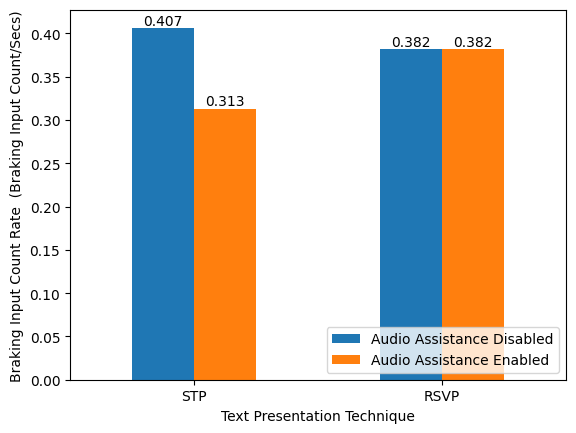

In [44]:
# Analysing the Breaking Input Rate
BIRs = []
for i in range(0, bi_df.shape[0]):
    dp_array = [dp for dp in bi_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    count = 0
    for value in dp_array:
        if value != 0:
            count += 1
    rate = float(count)/len(dp_array)
    BIRs.append(rate)
bi_df["RATE"] = BIRs

# Create seperate arrays for 2 x 2 cases
bir_stp = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 0)]["RATE"].values
bir_stpa = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 1)]["RATE"].values
bir_rsvp = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 0)]["RATE"].values
bir_rsvpa = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 1)]["RATE"].values

bir_results_array = np.array([
    ["STP",np.mean(bir_stp), np.mean(bir_stpa)],
    ["RSVP",np.mean(bir_rsvp), np.mean(bir_rsvpa)],
])

bir_results_df = pd.DataFrame(bir_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(bir_results_df)

# Converting the column types
bir_results_df["TPT"] = bir_results_df["TPT"].astype(str)
bir_results_df["AA Disabled"] = bir_results_df["AA Disabled"].astype(float)
bir_results_df["AA Enabled"] = bir_results_df["AA Enabled"].astype(float)


# Test if the distribution is normal.
print("Shapiro Test for BIR_stp; p-value: ", stats.shapiro(bir_stp)[1])
print("Shapiro Test for BIR_rsvp; p-value: ", stats.shapiro(bir_rsvp)[1])
print("Shapiro Test for BIR_stpa; p-value: ", stats.shapiro(bir_stpa)[1])
print("Shapiro Test for BIR_rsvpa; p-value: ", stats.shapiro(bir_rsvpa)[1])

data_is_normal = False

if (data_is_normal):
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: BIR_rsvp < BIR_stp
    print("H_a: BIR_rsvp = BIR_stp ; H_a: BIR_rsvp < BIR_stp")
    print(stats.ttest_rel(a = bir_rsvp, b = bir_stp, alternative = "less"))
    print("H_a: BIR_rsvpa = BIR_stpa ; H_a: BIR_rsvpa < BIR_stpa")
    print(stats.ttest_rel(a = bir_rsvpa, b = bir_stpa, alternative = "less"))

    # Test if H_a: BIR_aae < BIR_aad
    print("H_a: BIR_aae = BIR_aad ; H_a: BIR_aae < BIR_aad for RSVP")
    print(stats.ttest_rel(a = bir_rsvp, b = bir_rsvpa, alternative = "less"))
    print("H_a: BIR_aae = BIR_aad ; H_a: BIR_aae < BIR_aad for STP")
    print(stats.ttest_rel(a = bir_stp, b = bir_stpa, alternative = "less"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(bir_rsvp, bir_stp, alternative='less')
    print("Test: BIR_rsvp < BIR_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(bir_rsvpa, bir_stpa, alternative='less')
    print("Test: BIR_rsvpa < BIR_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(bir_rsvpa, bir_rsvp, alternative='less')
    print("Test: BIR_rsvpa < BIR_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(bir_stpa, bir_stp, alternative='less')
    print("Test: BIR_stpa < BIR_stp [p value: {}]".format(p4))

bplot = bir_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Braking Input Count Rate  (Braking Input Count/Secs)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

    TPT          AA Disabled           AA Enabled
0   STP  0.49906139596873866   0.3727739602625768
1  RSVP   0.4339099668124088  0.41830582375331177
Shapiro Test for MBI_stp; p-value:  0.8461998701095581
Shapiro Test for MBI_rsvp; p-value:  0.9049716591835022
Shapiro Test for MBI_stpa; p-value:  0.6903793811798096
Shapiro Test for MBI_rsvpa; p-value:  0.5855708122253418
Test: MBI_rsvp < MBI_stp [p value: 0.07781773037901928]
Test: MBI_rsvpa < MBI_stpa [p value: 0.7699542061366504]
Test: MBI_rsvpa < MBI_rsvp [p value: 0.4355927677377289]
Test: MBI_stpa < MBI_stp [p value: 0.03981336469106544]


C:\Users\Shiv Patel\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


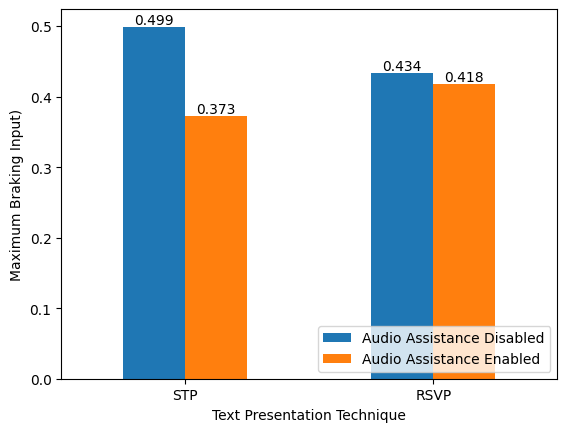

In [45]:
# Analysing the Maximum breaking input
MBIs = []
for i in range(0, bi_df.shape[0]):
    dp_array = [dp for dp in bi_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MBIs.append(max(dp_array))
bi_df["MAX"] = MBIs

# Create seperate arrays for 2 x 2 cases
mbi_stp = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 0)]["MAX"].values
mbi_stpa = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 1)]["MAX"].values
mbi_rsvp = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 0)]["MAX"].values
mbi_rsvpa = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 1)]["MAX"].values

mbi_results_array = np.array([
    ["STP",np.mean(mbi_stp), np.mean(mbi_stpa)],
    ["RSVP",np.mean(mbi_rsvp), np.mean(mbi_rsvpa)],
])

mbi_results_df = pd.DataFrame(mbi_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(mbi_results_df)

# Converting the column types
mbi_results_df["TPT"] = mbi_results_df["TPT"].astype(str)
mbi_results_df["AA Disabled"] = mbi_results_df["AA Disabled"].astype(float)
mbi_results_df["AA Enabled"] = mbi_results_df["AA Enabled"].astype(float)


# Test if the distribution is normal.
print("Shapiro Test for MBI_stp; p-value: ", stats.shapiro(mbi_stp)[1])
print("Shapiro Test for MBI_rsvp; p-value: ", stats.shapiro(mbi_rsvp)[1])
print("Shapiro Test for MBI_stpa; p-value: ", stats.shapiro(mbi_stpa)[1])
print("Shapiro Test for MBI_rsvpa; p-value: ", stats.shapiro(mbi_rsvpa)[1])

data_is_normal = False

if (data_is_normal):
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: MBI_rsvp < MBI_stp
    print("H_a: MBI_rsvp = MBI_stp ; H_a: MBI_rsvp < MBI_stp")
    print(stats.ttest_rel(a = mbi_rsvp, b = mbi_stp, alternative = "less"))
    print("H_a: MBI_rsvpa = MBI_stpa ; H_a: MBI_rsvpa < MBI_stpa")
    print(stats.ttest_rel(a = mbi_rsvpa, b = mbi_stpa, alternative = "less"))

    # Test if H_a: MBI_aae < MBI_aad
    print("H_a: MBI_aae = MBI_aad ; H_a: MBI_aae < MBI_aad for RSVP")
    print(stats.ttest_rel(a = mbi_rsvp, b = mbi_rsvpa, alternative = "less"))
    print("H_a: MBI_aae = MBI_aad ; H_a: MBI_aae < MBI_aad for STP")
    print(stats.ttest_rel(a = mbi_stp, b = mbi_stpa, alternative = "less"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(mbi_rsvp, mbi_stp, alternative='less')
    print("Test: MBI_rsvp < MBI_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(mbi_rsvpa, mbi_stpa, alternative='less')
    print("Test: MBI_rsvpa < MBI_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(mbi_rsvpa, mbi_rsvp, alternative='less')
    print("Test: MBI_rsvpa < MBI_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(mbi_stpa, mbi_stp, alternative='less')
    print("Test: MBI_stpa < MBI_stp [p value: {}]".format(p4))

bplot = mbi_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Maximum Braking Input)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

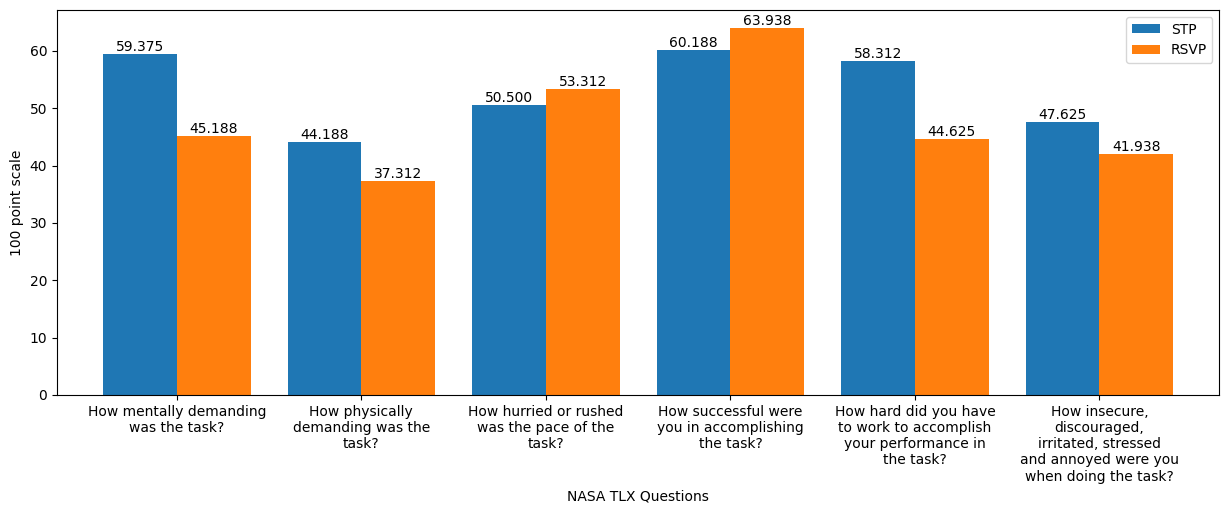

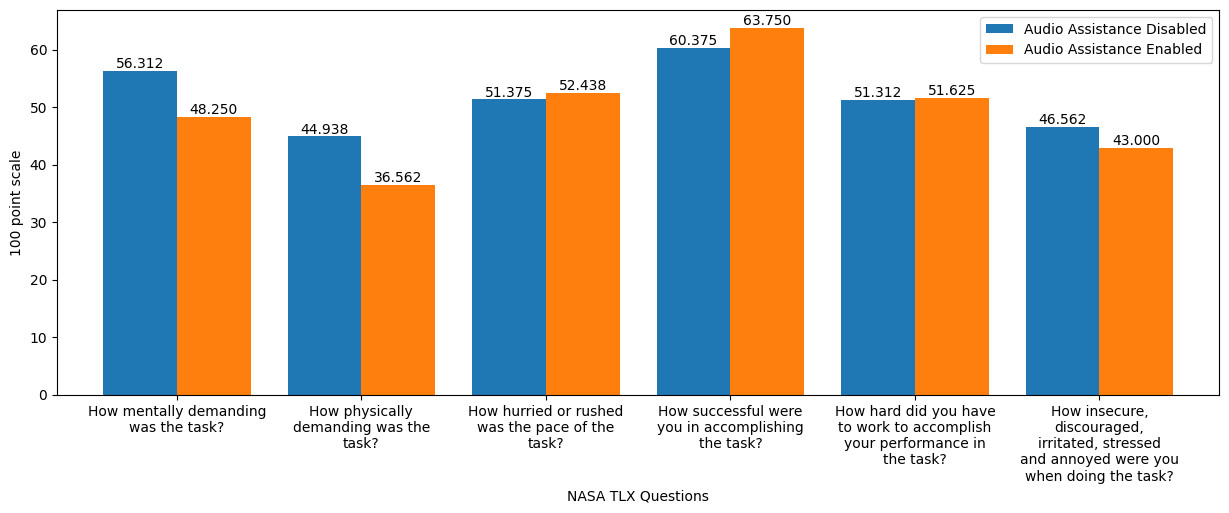

In [46]:
# Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Diplay
# Q3: Text Presentation Technique
# Q4_1 How mentally demanding was the task?
# Q4_2: How physically demanding was the task?
# Q4_3: How hurried or rushed was the pace of the task?
# Q4_4: How successful were you in accomplishing the task?
# Q4_5: How hard did you have to work to accomplish your performance in the task?
# Q4_6: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?
axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
labels = []
for label in axis_labels:
    labels.append(textwrap.fill(label, width=22,
                  break_long_words=False))

nasa_tlx_stp = nasa_tlx[nasa_tlx["Q3"] == "STP"]
nasa_tlx_rsvp = nasa_tlx[nasa_tlx["Q3"] == "RSVP"]
nasa_tlx_aae = nasa_tlx[nasa_tlx["Q2"] == "HUDAA"]
nasa_tlx_aad = nasa_tlx[nasa_tlx["Q2"] == "HUD"]

TPT_diff = np.array([
    ["Q1", np.mean(nasa_tlx_stp["Q4_1"]), np.mean(nasa_tlx_rsvp["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_stp["Q4_2"]), np.mean(nasa_tlx_rsvp["Q4_2"])],
    ["Q3", np.mean(nasa_tlx_stp["Q4_3"]), np.mean(nasa_tlx_rsvp["Q4_3"])],
    ["Q4", np.mean(nasa_tlx_stp["Q4_4"]), np.mean(nasa_tlx_rsvp["Q4_4"])],
    ["Q5", np.mean(nasa_tlx_stp["Q4_5"]), np.mean(nasa_tlx_rsvp["Q4_5"])],
    ["Q6", np.mean(nasa_tlx_stp["Q4_6"]), np.mean(nasa_tlx_rsvp["Q4_6"])],

])

AA_diff = np.array([
    ["Q1", np.mean(nasa_tlx_aad["Q4_1"]), np.mean(nasa_tlx_aae["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_aad["Q4_2"]), np.mean(nasa_tlx_aae["Q4_2"])],
    ["Q3", np.mean(nasa_tlx_aad["Q4_3"]), np.mean(nasa_tlx_aae["Q4_3"])],
    ["Q4", np.mean(nasa_tlx_aad["Q4_4"]), np.mean(nasa_tlx_aae["Q4_4"])],
    ["Q5", np.mean(nasa_tlx_aad["Q4_5"]), np.mean(nasa_tlx_aae["Q4_5"])],
    ["Q6", np.mean(nasa_tlx_aad["Q4_6"]), np.mean(nasa_tlx_aae["Q4_6"])],
])

nasa_tlx_tpt_df = pd.DataFrame(TPT_diff, columns = ["Question", "STP", "RSVP"])
nasa_tlx_aa_df = pd.DataFrame(AA_diff, columns = ["Question", "AAD", "AAE"])

# Converting the column types
nasa_tlx_tpt_df["Question"] = nasa_tlx_tpt_df["Question"].astype(str)
nasa_tlx_tpt_df["STP"] = nasa_tlx_tpt_df["STP"].astype(float)
nasa_tlx_tpt_df["RSVP"] = nasa_tlx_tpt_df["RSVP"].astype(float)

nasa_tlx_aa_df["Question"] = nasa_tlx_aa_df["Question"].astype(str)
nasa_tlx_aa_df["AAD"] = nasa_tlx_aa_df["AAD"].astype(float)
nasa_tlx_aa_df["AAE"] = nasa_tlx_aa_df["AAE"].astype(float)
                                                  
# RSVP vs STP
bplot = nasa_tlx_tpt_df.plot(x = "Question", kind = "bar", width = 0.8, rot = 0, figsize = (15, 5))

bplot.set_xticklabels(labels, rotation=0)

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')
    
# Audio assistance disabled vs audio assistance enabled
bplot2 = nasa_tlx_aa_df.plot(x = "Question", kind = "bar", width = 0.8, rot = 0, figsize = (15, 5))
bplot2.set_xticklabels(labels, rotation=0)
bplot2.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"])

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot2.containers:
    bplot2.bar_label(p, fmt='%.3f', label_type='edge')

,Participant_ID,TPT,Audio Assistance,Accuracy
0,P06,STP,NAA,90.000000
1,P06,STP,AA,30.000000
2,P06,RSVP,NAA,70.833333
3,P06,RSVP,AA,30.000000
4,P07,STP,NAA,100.000000
5,P07,STP,AA,80.000000
6,P07,RSVP,NAA,90.000000
7,P07,RSVP,AA,91.666667
8,P08,STP,NAA,87.500000
9,P08,STP,AA,90.000000


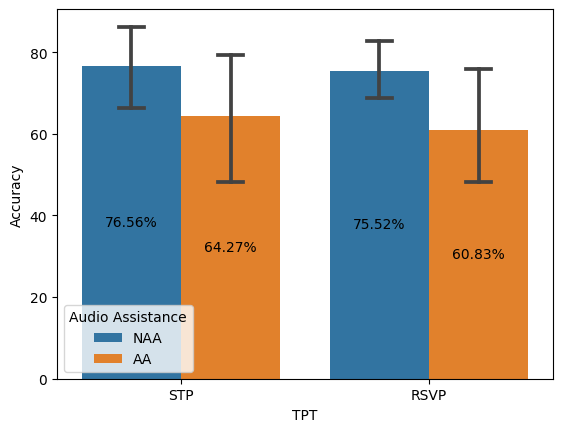

In [18]:
correct_answers = [1, 2, 3, 4, 2, 1, 3, 2, 4, 2, 4, 2, 3, 3, 4, 1, 2, 1, 3, 2, 1, 3, 4, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 2, 1, 4, 4, 4, 2]
acc_col = []
for i in range(0, comp_test_df.shape[0]):
    row = [dp for dp in comp_test_df.iloc[i].values.tolist()[4:]]
    correct = 0
    incorrect = 0
    for j in range(0, len(correct_answers)):
        if not math.isnan(row[j]):
            if row[j] == correct_answers[j]:
                correct += 1
            else:
                incorrect += 1
    acc_col.append(float(correct)/(correct+incorrect))

comp_test_acc_df = pd.DataFrame().assign(Participant_ID=comp_test_df['Q1'], AA=comp_test_df['Qa'], TPT=comp_test_df['Qb'], TF=comp_test_df['Qc'])
comp_test_acc_df['Accuracy']= acc_col
# AA = 1 If Enabled, 2 If Disabled
# TPT = 1 If STP, 2 If RSVP
# TF ranges between 1-8

# Creating a dataframe to plot the data
comp_test_refined_df = pd.DataFrame(columns=['Participant_ID', 'TPT', 'Audio Assistance', 'Accuracy'])
comp_test_refined_df["Accuracy"] = comp_test_refined_df["Accuracy"].astype(float)

for participant in comp_test_acc_df["Participant_ID"].unique():
    # Get the dataframe for the participant
    participant_df = comp_test_acc_df[comp_test_acc_df["Participant_ID"] == participant]
    
    # Get the dataframe for each of the four cases
    df_row_stp = [participant, "STP", "NAA"];
    df_row_rsvp = [participant, "RSVP", "NAA"];
    df_row_stpa = [participant, "STP", "AA"];
    df_row_rsvpa = [participant, "RSVP", "AA"];
    
    # Adding the stp NAA test value
    df_row_stp.append(participant_df[(participant_df["AA"]==2) & (participant_df["TPT"]==1)]["Accuracy"].values.mean()*100)
    # Adding the stp AA test value
    df_row_stpa.append(participant_df[(participant_df["AA"]==1) & (participant_df["TPT"]==1)]["Accuracy"].values.mean()*100)
    # Adding the rsvp NAA test value
    df_row_rsvp.append(participant_df[(participant_df["AA"]==2) & (participant_df["TPT"]==2)]["Accuracy"].values.mean()*100)
    # Adding the rsvpa AA test value
    df_row_rsvpa.append(participant_df[(participant_df["AA"]==1) & (participant_df["TPT"]==2)]["Accuracy"].values.mean()*100)
    
    # Adding the rows in the dataframe
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stpa
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvpa
    
plot = sns.barplot(data=comp_test_refined_df, x="TPT", y="Accuracy", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.2f%%', label_type='center')
display(comp_test_refined_df)